# UNETR-2D for mitochondria segmentation in 2D
    
     Author: Aitor González
---
<figure>
<center>
<img src="https://www.epfl.ch/labs/cvlab/wp-target/uploads/2018/08/FIBSLICE0035_left_top.png" alt="EM image" width="256">
<img src="https://www.epfl.ch/labs/cvlab/wp-target/uploads/2018/08/masks_FIBSLICE0035_left_top.png" alt="Binary label image" width="256">
<figcaption>Input image (left) and corresponding semantic segmentation (right)</figcaption>
</figure>


## Getting started

In [ ]:
from utils import *
from models import *

import os
import numpy as np
import cv2
import gc
import pandas as pd
from matplotlib import pyplot as plt
from skimage import metrics
from datetime import datetime
from time import time 

import tensorflow as tf
import tensorflow_addons as tfa # AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.backend import clear_session

set_gpu(gpu_id=0)
set_seed()

We download and unzip the dataset (it might take a few minutes but later it is faster than having the data directly as images in Drive):

In [5]:
if not os.path.exists('./Data'):
    # make a copy of the 
    # Unzip FIBSEM (EPFL) dataset
    !wget 'https://ehubox.ehu.eus/s/QnCc4L4ZYpHpB2s/download'
    !unzip -q download
    !rm download
    !mkdir Data
    !mv data Data/Lucchi

--2022-09-24 15:45:24--  https://ehubox.ehu.eus/s/QnCc4L4ZYpHpB2s/download
Resolving ehubox.ehu.eus (ehubox.ehu.eus)... 158.227.0.95
Connecting to ehubox.ehu.eus (ehubox.ehu.eus)|158.227.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225297821 (215M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 214.86M  2.47MB/s    in 1m 52s  

2022-09-24 15:47:18 (1.92 MB/s) - ‘download’ saved [225297821/225297821]



Now we should be able to read the list of **165 training images** and their corresponding 165 label images, that are organized as follows:

```
data/
    |-- train/
    |    |-- x/
    |    |      training-0001.tif
    |    |      ...
    |    |-- y/
    |    |      training_groundtruth-0001.tif
    |    |        ...
    |-- test/
    |    |-- x/
    |    |      testing-0001.tif
    |    |      ...
    |    |-- y/
    |    |      testing_groundtruth-0001.tif
    |    |      ...

```

## Parameters

In [6]:
data_path = './Data/'
# Training dataset
train_datasets = 'Lucchi'
# Test dataset
test_datasets = 'Lucchi'

In [7]:
## === Training parameters ===
# number of epochs
numEpochs = 150
# patience (if (patience <= 0): patience will not be used)
patience = 30
# learning rate
lr = 1e-4
# weight_decay  (for AdamW)
wd = 1e-5
# Scheduler: 'oneCycle', 'reduce', 'cosine',  None
schedule = 'oneCycle'
# Optimizer name: 'Adam', 'SGD', 'rmsprop', 'AdamW'
optimizer_name = 'AdamW'
# Loss function name: 'bce', 'bce_dice', 'mse'
loss_acronym = 'bce'
# batch size
batch_size_value = 6

In [8]:
## === Network parameters ===
# Network architecture: UNETR_2D, YNETR_2D,
model_name = 'UNETR_2D'
# initial filters (16 x num_channels)
num_filters = 32
# conv kernel initializer: 'glorot_uniform', 'he_normal'
kernel_init = 'he_normal'
# conv part activation function
activation = 'relu'
# patch size
patch_size = 16
# hidden dimension
hidden_dim = 64
# number of transformer encoders
transformer_layers = 4
# number of heads per MHA module
num_heads = 4
# transformer mlp dimentions
mlp_dim = [256, 64]
# number of output channels (number of classes)
out_channels = 1
# denoise type: cutout, gaussNoise, coarseSaltP, emulate_LR, gaussian_filter, defocusBlur, motionBlur, pixeldropout
posible_dataAug = []
# freeze part of the network
freeze = False
# dropout value # [0.1, 0.1, 0.2, 0.2, 0.3] (list is also allowed)
dropout = 0.0
# multiple of ViT layers that will be used for each skip connection (Sm)
ViT_hidd_mult_skipC = 1
# Use Batch Normalization layers
batch_norm = True
# Use Data Augmentation
da = True
# tensorflow additional data augmentation layers (use tf layer, if multiple layers, then use sequential() and add them)
extra_tf_data_augmentation = None

In [9]:
# === Extra parameters ===
# Load weights for FineTunning
use_saved_model = False
# Path to save weights (After training)
out_dir = './model_weights'
# Path to save images
img_out_dir = './plots'
# filenames for trained model weights (h5)
weights_filename = out_dir + '/weights-{}-src-{}-bce-nf-{}-bs-{}-{}-{}.h5'.format(
                                                    model_name, train_datasets, num_filters, batch_size_value,
                                                    optimizer_name, 'None' if schedule is None else schedule )
# Weights file path (weights that will be loaded if use_saved_model is TRUE)
model_path = ''

# image input size (this does not change the data size!)
input_shape = (256,256,1)
# number of random patches (with number lower than 0, sequential patches will be used)
n_patches = -1

# evaluation parameters
# patch size
patch_h, patch_w = (256,256)
# relevant patch size
relevant_h, relevant_w = (128,128)

## Get data

In [10]:
h_cuts = 0
v_cuts = 0

source_path = os.path.join(data_path, train_datasets, 'train')
ds_imgs, ds_lbls = get_xy_image_list(source_path)

assert len(ds_imgs) > 0, 'There in NO data, check path: {}.'.format(source_path)
assert len(ds_imgs) == len(ds_lbls), 'There is different ammount of images and labels. Images: {}  Labels: {}'.format(len(ds_imgs), len(ds_lbls))

h, w = ds_imgs[0].shape
exp_h, exp_w, _ = input_shape

h_cuts = int(np.ceil(w/exp_w))
v_cuts = int(np.ceil(h/exp_h))

#print("h_cuts: {} \t v_cuts: {}".format(h_cuts, v_cuts))

if w%exp_w != 0 and h%exp_h != 0:
    w_parts = w/exp_w
    h_parts = h/exp_h
    new_w = int(np.ceil(w_parts))*exp_w
    new_h = int(np.ceil(h_parts))*exp_h
    # MIRROR PADDING
    ds_imgs = [mirror_border(x, new_h, new_w) for x in ds_imgs]
    ds_lbls = [mirror_border(x, new_h, new_w) for x in ds_lbls]
    # ZERO PADDING (for 256x256 patches by default)
    #ds_imgs = [add_padding(x) for x in ds_imgs]
    #ds_lbls = [add_padding(x) for x in ds_lbls]

if n_patches < 0:
    # sequential patches
    ds_imgs = create_patches( ds_imgs, h_cuts, v_cuts )
    ds_lbls = create_patches( ds_lbls, h_cuts, v_cuts )

    #ds_imgs, ds_lbls = filter_patches(ds_imgs, ds_lbls)
else:
    # random patches
    p_ds_imgs = []
    p_ds_lbls = []
    while len(p_ds_imgs)<n_patches:
        a,b = create_random_patches( ds_imgs, ds_lbls, 1, [256, 256] )
        #a, b = filter_patches(a, b)
        p_ds_imgs = p_ds_imgs + a
        p_ds_lbls = p_ds_lbls + b
    ds_imgs = p_ds_imgs[:n_patches]
    ds_lbls = p_ds_lbls[:n_patches]

ds_imgs = np.expand_dims(ds_imgs, axis=-1)
ds_lbls = np.expand_dims(ds_lbls, axis=-1)

input_images = np.array(ds_imgs)
gt_labels = np.array(ds_lbls)

train_data_size = input_images.shape[0] * 0.9
val_data_size = input_images.shape[0] * 0.1

print('\n Data shape:',input_images.shape)

Input images loaded: 165 -- Label images loaded: 165
	path: ./Data/Lucchi/train

 Data shape: (1980, 256, 256, 1)


In [11]:
# get crappify function
crappify = get_crappify(posible_dataAug) 
# Get generator
train_generator, val_generator = get_train_val_generators(  X_data = input_images,
                                                            Y_data = input_images if loss_acronym == 'mse' else gt_labels,
                                                            validation_split = 0.1,
                                                            rescale = 1./255,
                                                            horizontal_flip=True if da else False,
                                                            vertical_flip=True if da else False,
                                                            rotation_range = 180 if da else 0,
                                                            #width_shift_range=0.2,
                                                            #height_shift_range=0.2,
                                                            #shear_range=0.2,
                                                            batch_size=batch_size_value,
                                                            show_examples=False,
                                                            preprocessing_function = crappify if loss_acronym == 'mse' else None,
                                                            val_preprocessing_function = crappify if loss_acronym == 'mse' else None, )

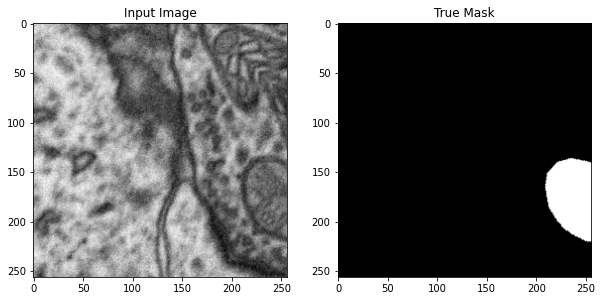

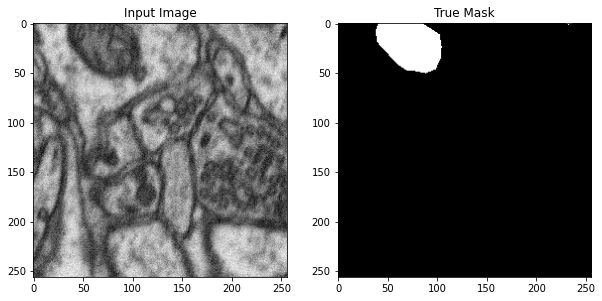

In [12]:
for x, y in train_generator:
    display([x[0,:,:,0],y[0,:,:,0]])
    break
for x, y in val_generator:
    display([x[0,:,:,0],y[0,:,:,0]])
    break

## Compile


In [13]:
# Free up RAM in case the model definition cells were run multiple times
clear_session()
gc.collect()

### CALLBACKS ###
callbacks = []

if patience > 0:
    # callback for early stop
    earlystopper = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)
    callbacks.append(earlystopper)

if schedule == 'oneCycle':
    # callback for one-cycle schedule
    steps = np.ceil(train_data_size / batch_size_value) * numEpochs
    #steps = np.ceil(len(X_train) / batch_size_value) * numEpochs
    lr_schedule = OneCycleScheduler(lr, steps)
    callbacks.append(lr_schedule)
elif schedule == 'reduce':
    # callback to reduce the learning rate in the plateau
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=patience, min_lr=(lr/10))
    callbacks.append(lr_schedule)
elif schedule == 'cosine':
    # this scheduler is not a callback
    steps = np.ceil(train_data_size / batch_size_value) * numEpochs
    lr = tf.keras.optimizers.schedules.CosineDecay(lr, steps)  


# create the network and compile it with its optimizer
if model_name == 'UNETR_2D':
    model = UNETR_2D(
            input_shape = input_shape,
            patch_size = patch_size,
            num_patches = (input_shape[0]**2)//(patch_size**2),
            projection_dim = hidden_dim,
            transformer_layers = transformer_layers,
            num_heads = num_heads,
            transformer_units = mlp_dim, 
            data_augmentation = extra_tf_data_augmentation,
            num_filters = num_filters,
            num_classes = out_channels,
            decoder_activation = activation,
            decoder_kernel_init = kernel_init,
            ViT_hidd_mult=ViT_hidd_mult_skipC,
            batch_norm = batch_norm,
            dropout = dropout,
        )
elif model_name == 'YNETR_2D':   
    model = YNETR_2D(
                input_shape = input_shape,
                patch_size = patch_size,
                num_patches = (input_shape[0]**2)//(patch_size**2),
                projection_dim = hidden_dim,
                transformer_layers = transformer_layers,
                num_heads = num_heads,
                transformer_units = mlp_dim, 
                data_augmentation = extra_tf_data_augmentation,
                num_filters = num_filters, 
                num_classes = out_channels,
                activation = activation,
                kernel_init = kernel_init,
                ViT_hidd_mult=ViT_hidd_mult_skipC,
                batch_norm = batch_norm,
                dropout = dropout,
            )
        

if optimizer_name == 'SGD':
    optim =  tf.keras.optimizers.SGD(
            lr=lr, momentum=0.99, decay=0.0, nesterov=False)
elif optimizer_name == 'Adam':
    optim = tf.keras.optimizers.Adam( learning_rate=lr )
elif optimizer_name == 'rmsprop':
    optim = tf.keras.optimizers.RMSprop( learning_rate=lr )
elif optimizer_name == 'AdamW':
    optim = tfa.optimizers.AdamW( weight_decay = wd, learning_rate=lr )

model.summary()

if loss_acronym == 'bce':
    loss_funct = 'binary_crossentropy'
elif loss_acronym == 'bce_dice':
    loss_funct = bce_dice_loss
elif loss_acronym == 'mse': # dont change this acronym (is used to know when is training for denoising)
    loss_funct = 'mean_squared_error'

if loss_acronym == 'mse':
    eval_metric = [psnr, ssim]
else:
    eval_metric = jaccard_index     
                
# compile the model with the specific optimizer, loss function and metric
model.compile(optimizer=optim, loss=loss_funct, metrics=eval_metric)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 patches (Patches)              (None, None, 256)    0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 256, 64)      32832       ['patches[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 256, 64)     128         ['patch_encoder[0][0]']      

### show model architecture
Have a quick look at the resulting model architecture:

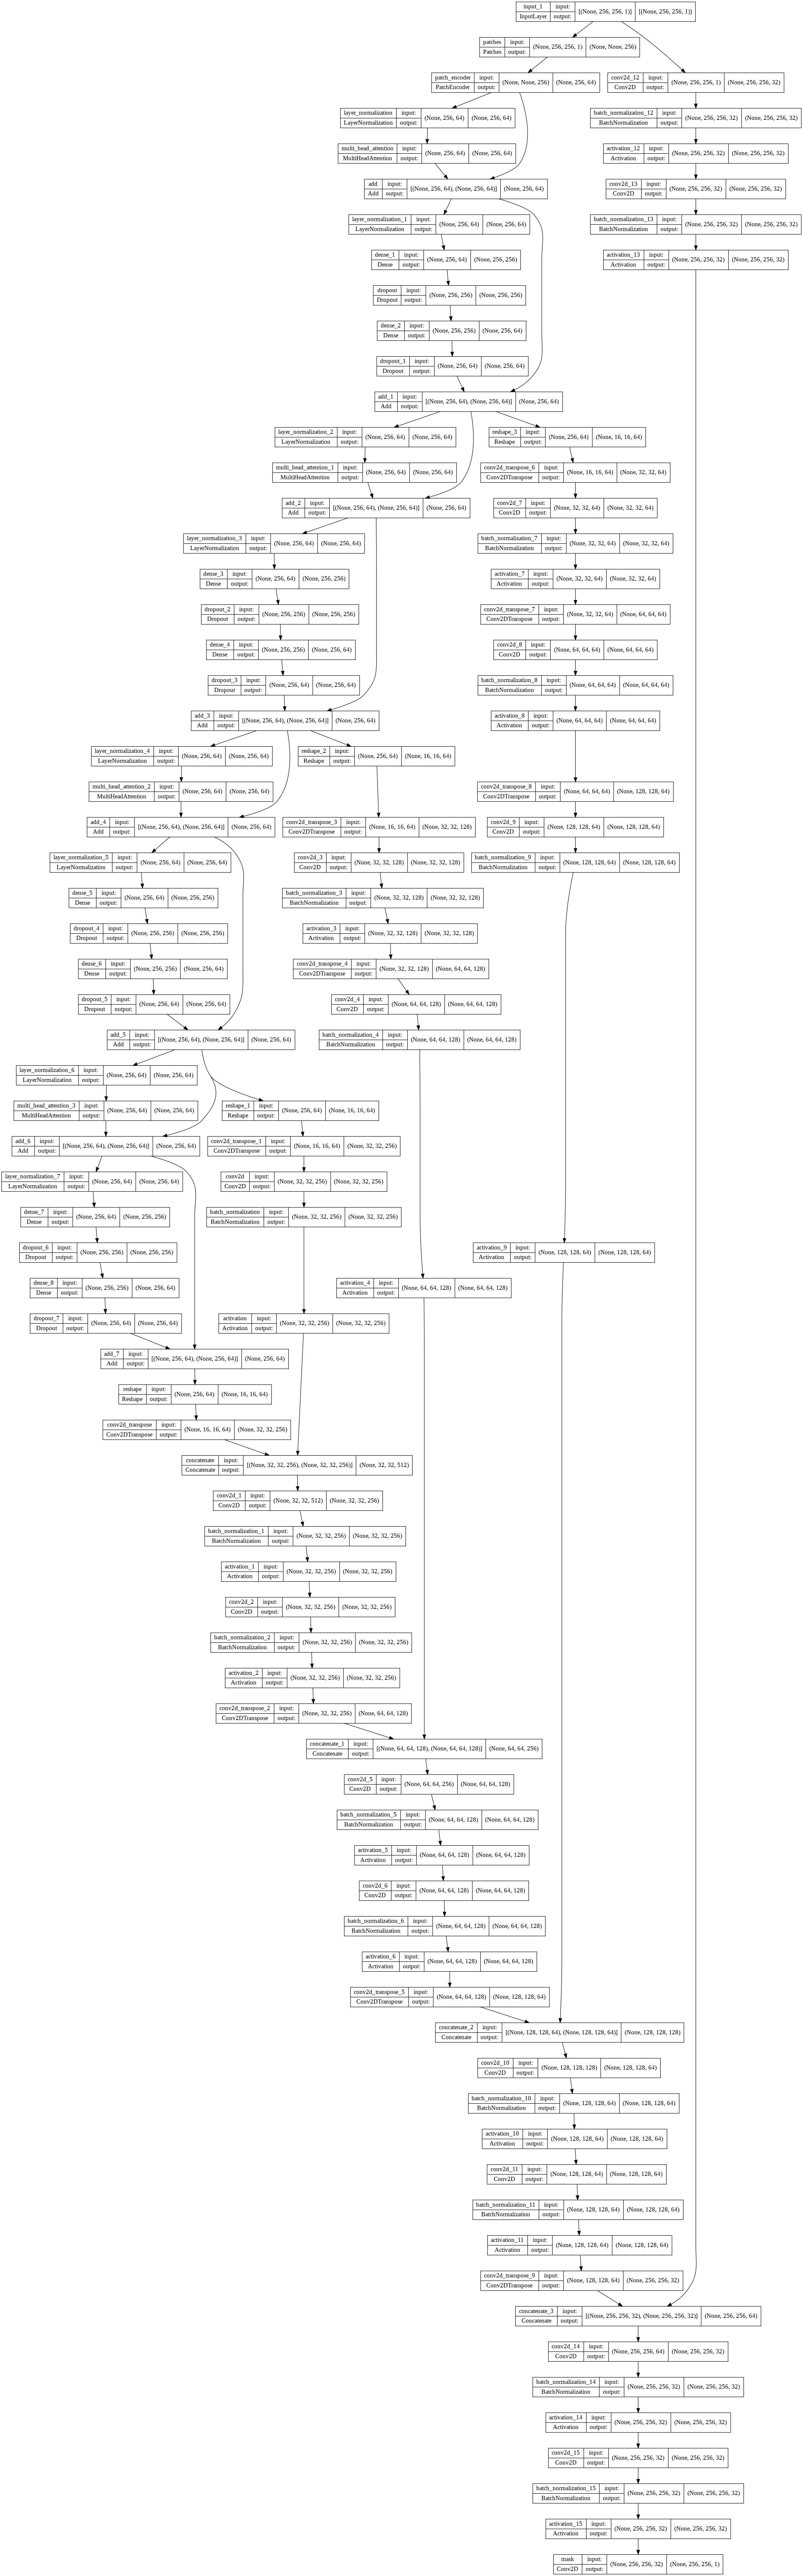

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Load saved model

In [15]:
if use_saved_model:
    # Restore the weights
    model.load_weights(model_path) # change this

    # compile the model with the specific optimizer, loss function and metric
    model.compile(optimizer=optim, loss=loss_funct, metrics=eval_metric)
    print("Weights loaded, and compiled")


## Train model

In [16]:
history = model.fit(train_generator, validation_data=val_generator,
                    validation_steps=np.ceil(val_data_size/batch_size_value),
                    steps_per_epoch=np.ceil(train_data_size/batch_size_value),
                    epochs=numEpochs, callbacks=callbacks)

Epoch 1/150
297/297 [==============================] - 67s 150ms/step - loss: 0.4533 - jaccard_index: 0.0804 - val_loss: 0.4779 - val_jaccard_index: 0.0571
Epoch 2/150
297/297 [==============================] - 45s 151ms/step - loss: 0.4136 - jaccard_index: 0.1612 - val_loss: 0.3665 - val_jaccard_index: 0.0774
Epoch 3/150
297/297 [==============================] - 46s 155ms/step - loss: 0.3757 - jaccard_index: 0.2711 - val_loss: 0.3361 - val_jaccard_index: 0.1366
Epoch 4/150
297/297 [==============================] - 46s 154ms/step - loss: 0.3275 - jaccard_index: 0.3261 - val_loss: 0.2839 - val_jaccard_index: 0.1905
Epoch 5/150
297/297 [==============================] - 46s 155ms/step - loss: 0.2883 - jaccard_index: 0.3528 - val_loss: 0.2526 - val_jaccard_index: 0.2652
Epoch 6/150
297/297 [==============================] - 46s 154ms/step - loss: 0.2595 - jaccard_index: 0.3673 - val_loss: 0.2317 - val_jaccard_index: 0.2920
Epoch 7/150
297/297 [==============================] - 46s 154ms

Plot loss - IoU

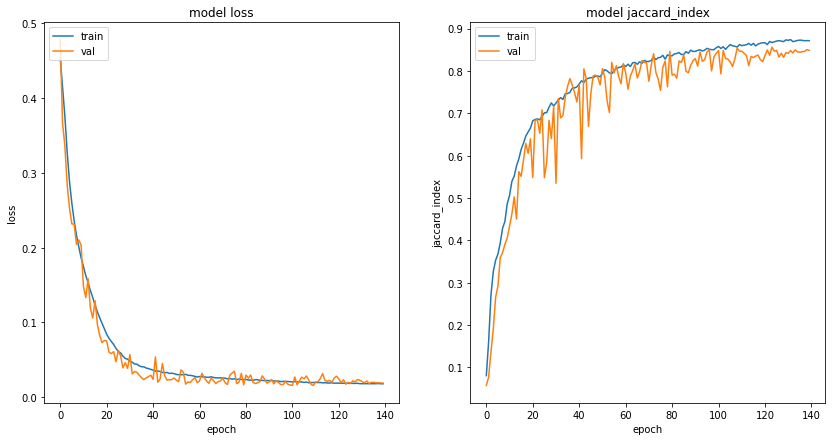

In [17]:
track_metrics = ['loss', 'psnr', 'ssim'] if loss_acronym == 'mse' else ['loss', 'jaccard_index']
curve_name = 'loss-metric_curve_' + test_datasets + '_.png'
create_dir(img_out_dir)
plot_loss_and_metric(track_metrics, history, figsize=(14,7), save_fig_path=os.path.join(img_out_dir, curve_name))

### Save weights

In [18]:
# Save weights for future reuse
create_dir(out_dir)
model.save_weights( weights_filename )
print( 'Saved model as ' + weights_filename )

Saved model as ./model_weights/weights-UNETR_2D-src-Lucchi-bce-nf-32-bs-6-AdamW-oneCycle.h5


## Evaluation
\+ display examples

Method: Relevant patch with mirror padding

In [19]:
### FULL IMAGE using relevant patch + sliding window + mirror padding
print('TEST: ', test_datasets)
source_test_data_path = os.path.join(data_path, test_datasets, 'test')
test_img, test_lbl = get_xy_image_list(source_test_data_path)

# Prepare the test data
X_test = [x/255 for x in test_img] # normalize between 0 and 1
X_test = np.expand_dims( np.asarray(X_test, dtype=np.float32), axis=-1 ) # add extra dimension
Y_test = [x/255 for x in test_lbl] # normalize between 0 and 1
Y_test = np.expand_dims( np.asarray(Y_test, dtype=np.float32), axis=-1 ) # add extra dimension

b, h, w, c = X_test.shape
print("\nTest shape =", X_test.shape )
del test_img, test_lbl

TEST:  Lucchi
Input images loaded: 165 -- Label images loaded: 165
	path: ./Data/Lucchi/test

Test shape = (165, 768, 1024, 1)


Inferring and measuring

In [20]:
from tqdm.notebook import tqdm
# Now, we calculate the final test metrics
test_iou = []
test_psnr = []
test_ssim = []
test_mse = []
preds_test = []
input_test = []
i = 0

for img in tqdm(X_test):

    h, w, _ = img.shape

    if w%relevant_w != 0 and h%relevant_h != 0:
        w_parts = w/relevant_w
        h_parts = h/relevant_h
        new_w = int(np.ceil(w_parts))*relevant_w
        new_h = int(np.ceil(h_parts))*relevant_h
        pad_h = new_h - h # if pad==11 (odd): 6 top (near 0) - 5 bot
        pad_w = new_w - w # if pad==11 (odd): 6 L   (near 0) - 5 R
        same_shape_windows = False
    else:
        new_h = h + relevant_h
        new_w = w + relevant_w
        pad_h = relevant_h
        pad_w = relevant_w
        same_shape_windows = True

    image = np.expand_dims(mirror_border(img[:,:,0], new_h, new_w), axis=-1)

    rows = []
    x_rows = []
    # crete patches of (patch_h, patch_w) with (relevant_h, relevant_w) overlap between them
    for j in range(0, image.shape[0]-relevant_h, relevant_h): 

        is_first_column = j == 0
        is_last_column = j == (image.shape[0]-relevant_h*2)

        columns = [] # patches of the first row
        for k in range(0, image.shape[1]-relevant_w, relevant_w):
            window = image[j:j + patch_h, k:k + patch_w, :]
            columns.append( window )
        columns = np.array(columns)
        
        # prepare input and gt (y)
        if loss_acronym == 'mse':
            y = img[:,:,0]
            columns = np.array(columns*255, dtype='uint8')
            columns = crappify(columns)
            columns = np.array(columns, dtype='float32')/255
        else:
            y = Y_test[i,:,:,0]

        _preds_test = model.predict_on_batch(columns)#, batch_size=columns.shape[0])

        if same_shape_windows:
            #all the patches contain the same padding so we can extract them directly
            relevant_windows = _preds_test[ :, relevant_h//2 : patch_h-(relevant_h//2),
                                            relevant_w//2 : patch_w-(relevant_w//2), :]

            x_relevant = columns[ :, relevant_h//2 : patch_h-(relevant_h//2),
                                    relevant_w//2 : patch_w-(relevant_w//2), :]
        else:
            # if pad==11 (odd): 5 top (near 0) - 6 bot
            # if pad==11 (odd): 6 L   (near 0) - 5 R

            # pad_h//2 padding in the top side  &&  round(pad_h/2)-1 padding in the bottom side
            from_row = pad_h//2 if is_first_column else relevant_h//2
            to_row = -round(pad_h/2) if is_last_column else patch_h-(relevant_h//2) 

            # remove especial (smaller) padding in the top and bottom side, of the first or last row
            relevant_windows = _preds_test[ :, from_row : to_row, relevant_w//2 : patch_w - (relevant_w//2), :]
            x_relevant = columns[ :, from_row : to_row, relevant_w//2 : patch_w - (relevant_w//2), :]
            

            # convert into list otherwise numpy raise an error due to the shape differences
            relevant_windows = [im for im in relevant_windows]
            x_relevant = [im for im in x_relevant]


            # remove especial (smaller) padding in the sides
            # the relevant window contain round(pad_w/2) size padding in the left side
            from_column_L = round(pad_w/2)
            to_column_L = patch_w-(relevant_w//2)
            # the relevant window contain (pad_w//2) size padding in the right side
            from_column_R = relevant_w//2
            to_column_R = -(pad_w//2)
            
            # first column (left padding)
            relevant_windows[0] = _preds_test[0, from_row : to_row, from_column_L : to_column_L, :]
            x_relevant[0] = columns[0, from_row : to_row, from_column_L : to_column_L, :]
            # last column (right padding)
            relevant_windows[-1] = _preds_test[-1, from_row : to_row, from_column_R : to_column_R, :]
            x_relevant[-1] = columns[-1, from_row : to_row, from_column_R : to_column_R, :]
        
        rows.append(cv2.hconcat(relevant_windows)) # append relevant complete row
        x_rows.append(cv2.hconcat(x_relevant))

    x_recons = cv2.vconcat(x_rows)
    input_test.append(x_recons)
    recons_parts = cv2.vconcat(rows)
    preds_test.append(recons_parts) # append complete image

    if loss_acronym == 'mse':
        test_psnr.append(metrics.peak_signal_noise_ratio(recons_parts, y))
        test_ssim.append(metrics.structural_similarity(recons_parts, y))
        test_mse.append(metrics.mean_squared_error(recons_parts, y))
    else:
        test_iou.append( jaccard_index(y, recons_parts >= 0.5 ))     
    
    i+=1      
    

if loss_acronym == 'mse':
    mean_psnr = np.mean(test_psnr)
    mean_ssim = np.mean(test_ssim)
    mean_mse = np.mean(test_mse)
    print("\nTest PSNR:", mean_psnr)
    print("\nTest SSIM:", mean_ssim)
    print("\nTest MSE:", mean_mse)
else:
    mean_iou = np.mean(test_iou)
    print("\nTest IoU:", mean_iou)

  0%|          | 0/165 [00:00<?, ?it/s]


Test IoU: 0.846540433961524


Show inference examples

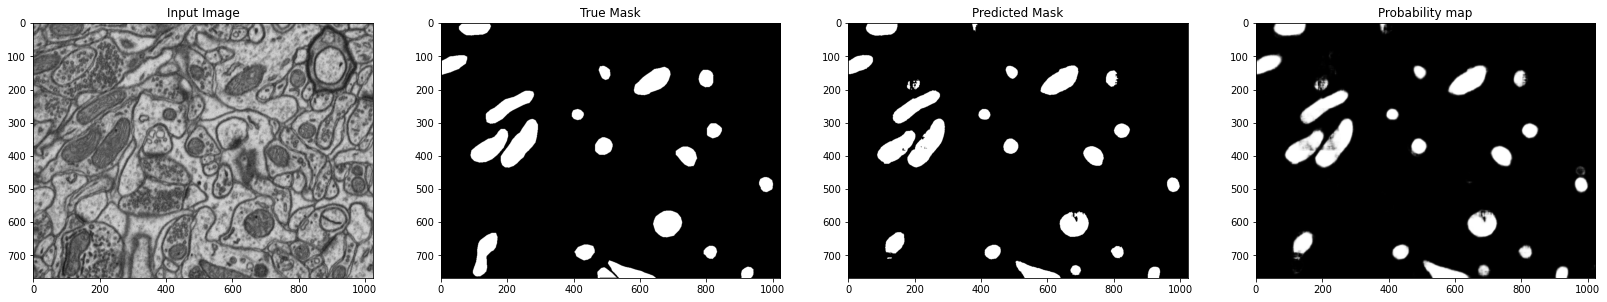

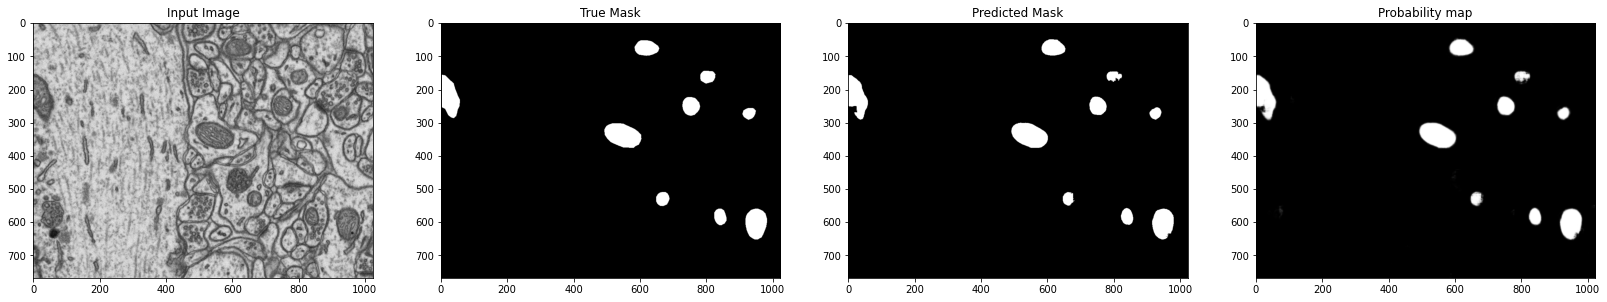

In [21]:
first_pred_img_name = 'first pred plot.png'
last_pred_img_name = 'last pred plot.png'

if loss_acronym == 'mse':
    display_list1 = [input_test[0], X_test[0,:,:,0], preds_test[0]]
    display_list2 = [input_test[-1], X_test[-1,:,:,0], preds_test[-1]]
    display_titles = ['Input full image', 'Ground Truth', 'Predicted image']
else:
    display_list1 = [X_test[0,:,:,0], Y_test[0,:,:,0], preds_test[0]>=.5, preds_test[0]]
    display_list2 = [X_test[-1,:,:,0], Y_test[-1,:,:,0], preds_test[-1]>=.5, preds_test[-1]]
    display_titles = ['Input Image', 'True Mask', 'Predicted Mask', 'Probability map']

plt.figure(figsize=(7*4,7))
display(display_list1,
        custom_size = True,
        save_fig_path = os.path.join(img_out_dir,first_pred_img_name),
        title = display_titles,
        )
plt.figure(figsize=(7*4,7))
display(display_list2,
        custom_size = True,
        save_fig_path = os.path.join(img_out_dir,last_pred_img_name),
        title = display_titles,
        )